### Case study for 1d toy model

This is a case study for a toy model that describes a chirping waveform

$h(t;a,f,\dot{f},\epsilon) = a \sin (2\pi t[f + \dot{f}t](1 - \epsilon))$

Here $\epsilon \ll 1$ is used as a tuneable parameter allowing deviations from an exact model $h_{\text{e}}(t;\boldsymbol{\theta},\epsilon = 0)$ given by an approximate model $h_{\text{m}}(t;\boldsymbol{\theta}, \epsilon \neq 0)$. We only consider a single data stream and use the approximate lisa-like PSD.

Set $\epsilon = 10^{-6}$ as the approximate waveform model $h_{\text{m}}$ while $\epsilon = 0$ for the exact waveform model $h_{\text{e}}$.

Firstly we treat $\dot{f}$ as an unknown parameter and set the rest at the default values. So this is a 1d parameter inference problem.

| parameter | default_value | prior_distribution | prior_range|
|-----------|------------|--------------------|------------|
| $\dot{f}$ | $10^{-8}$  | uniform|$10^{-13}$|
| $a$ | $5\cdot 10^{-21}$  |-|-|
| $f$ | $10^{-3}$  | -|-|

#### generate the training dataset

To obtain the estimator, we need to have training set $\{d_{j}, c_{j}, \alpha_{j}\}$.
1. $\alpha_{j}$ is the nominal level; samples from $p(\alpha)$ (uniform defaulted)

2. $d_{j}$ is the data stream that contains the noise 
    1. samples from $p(d|\theta)$, $\theta_{j}$ are samples from the prior distribution $p(\theta)$
    2. the noise was considered when getting the $d_{j}$, i.e. $d_{j}=h(\theta_{j})+noise$

3. $c_{j}$ is the indicator of whether the Bayesian credible set approximation contains the $\theta_{j}$

#### Following is the process of generating 5000 samples and the test signal d_{o}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

from LISA_utils import PowerSpectralDensity, FFT, freq_PSD, inner_prod, waveform


def deriv_waveform(fdot,t,phi,eps):
    """
    This is a function. It takes in a value of the amplitude $a$, frequency $f$ and frequency derivative $\dot{f}
    and a time vector $t$ and spits out whatever is in the return function. Modify amplitude to improve SNR. 
    Modify frequency range to also affect SNR but also to see if frequencies of the signal are important 
    for the windowing method. We aim to estimate the parameters $a$, $f$ and $\dot{f}$.
    """
    a = 5e-21
    f = 1e-3

    return (a *(np.sin(((2*np.pi)*(f*t + 0.5*fdot * t**2)*(1-eps) + phi))))

def Gaussian(values,mean,std):
    return np.exp(-(values - mean)**2 / (2*std**2))


def llike(fdot,t, data_f, variance_noise_f,eps):
    """
    Computes log likelihood 
    Assumption: Known PSD otherwise need additional term
    Inputs:
    data in frequency domain 
    Proposed signal in frequency domain
    Variance of noise
    """

    signal_prop_t = waveform(fdot,t,eps)
    signal_prop_f = FFT(signal_prop_t)

    inn_prod = sum((abs(data_f - signal_prop_f)**2) / variance_noise_f)

    return(-0.5 * inn_prod)


prior_sample_num=5000
prior_range=1e-13
fdot_true=1e-8
eps_true=1e-6

tmax =  120*60*60                 # Final time
fs = 2*1e-3                     # Sampling rate
delta_t = np.floor(0.01/fs)       # Sampling interval
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]
   
h_true_t = waveform(fdot_true,t,0)
h_true_f = FFT(h_true_t) 
# the test signal d_{o} is without noise
data_f = h_true_f          # Construct data stream d_{o}

y_sample=np.zeros((prior_sample_num+1,len(data_f)))
y_sample[0]=data_f.real
c=np.zeros(prior_sample_num)
nominal_l=np.zeros(prior_sample_num)

for s in tqdm(range(prior_sample_num)):
    
    np.random.seed(s*2023)
    # 2.A
    # generate fdot_prior
    fdot_prior_sample = np.random.uniform(1e-8-prior_range,1e-8+prior_range)  
    true_params = fdot_prior_sample

    tmax =  120*60*60                 # Final time
    fs = 2*1e-3                     # Sampling rate
    delta_t = np.floor(0.01/fs)       # Sampling interval

    t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]

    N_t = int(2**(np.ceil(np.log2(len(t)))))   # Round length of time series to a power of two. 
                                            
    h_true_t = waveform(true_params,t,0)

    h_true_f = FFT(h_true_t)         # Compute true signal in frequency domain

    freq,PSD = freq_PSD(t,delta_t)  # Extract frequency bins and PSD.

    # SNR2 = inner_prod(h_true_f,h_true_f,PSD,delta_t,N_t)    # Compute optimal matched filtering SNR
    # print("SNR of source",np.sqrt(SNR2))
    variance_noise_f = N_t * PSD / (4 * delta_t)            # Calculate variance of noise, real and imaginary.
    N_f = len(variance_noise_f)                             # Length of signal in frequency domain

    # Generate frequency domain noise
    noise_f = np.random.normal(0,np.sqrt(variance_noise_f),N_f) + 1j*np.random.normal(0,np.sqrt(variance_noise_f),N_f) 
    
    # get the 2.A: samples of from 𝑝(𝑑|𝜃)
    data_f = h_true_f + noise_f         # Construct data stream for d_{j}
    
    y_sample[s+1]=data_f.real # only consider the real part
    
    # Fisher Matrix computation
    exact_deriv_fdot_est = (0.5) * (2*np.pi * t**2)*(1-eps_true) * deriv_waveform(true_params,t, np.pi/2,eps_true)
    deriv_fdot_fft_est = FFT(exact_deriv_fdot_est)
    deriv_vec_est = deriv_fdot_fft_est
    Fisher_Matrix_est = inner_prod(deriv_vec_est,deriv_vec_est,PSD,delta_t,N_t)
    Cov_Matrix_est = 1/Fisher_Matrix_est
    precision_est = np.sqrt(Cov_Matrix_est)

    #===================== COMPUTE FORECAST BIAS ========================
    h_approx_t = waveform(true_params,t, eps_true)    # Compute approximate waveform model 
    h_approx_f = FFT(h_approx_t)                      # Compute approximate model frequency domain
    residuals_f = h_true_f - h_approx_f+noise_f

    biass = inner_prod(deriv_vec_est,residuals_f,PSD,delta_t,N_t)
    bias_para = biass/Fisher_Matrix_est    # Compute bias
    
    # 1 samples from  𝑝(𝛼)
    nominal=np.random.uniform(0.78,0.97)  
    nominal_l[s]=nominal

    # calucate c_{j}: whether the approximate Bayesian credible set contains the \theta_{j}
    if np.abs(bias_para)<=norm.ppf(1-(1-nominal)/2)*precision_est:
        c[s]=1

np.save("./c_samples.npy",c)
np.save("./y_samples.npy",y_sample)
np.save("./nominal_samples.npy",nominal_l)
print(np.mean(c))
# print(nominal_l.shape)
# print(y_sample.shape)

100%|██████████| 5000/5000 [03:28<00:00, 23.97it/s]


0.7122


### The data is ready, then train the model

#### dimension reduction
Here, we used tensorflow to build a autoencoder to make dimension reduction since the dimension of predictor is higher than a sample size, and the high dimension of the signals lead to the unbalanced information between nominal level and signals in input space.

In [2]:
import tensorflow as tf
tf.random.set_seed(123)
from tensorflow import keras
from keras.layers import Dense
from keras import Input, Model, regularizers,optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# normalization
scaler0 =StandardScaler()

y_sample=np.load("./y_samples.npy")
y_sample_s=scaler0.fit_transform(y_sample[1:])

# test signal d_{o}
yo=scaler0.transform(y_sample[0].reshape(1,-1))
# train signal d
ys=y_sample_s

print("the dimension of the signal",ys.shape[1],"is much larger than samplesize",ys.shape[0])


the dimension of the signal 65536 is much larger than samplesize 5000


#### build the autoencoder with activation of tanh and relu
`tanh` is a smooth activation function and can deal with negative values, so we used it in the first layer of encoder. Since `relu` is more simple, so it was used in the remaining layers. Regulations were used to reduce overfitting in the first and second layers of encoder.

In [3]:
# Building the Input Layer
input_layer= Input(shape=(65536,))

# encoded representation of input
encoded1 = Dense(2048, activation='tanh',activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded2 = Dense(512, activation='relu',activity_regularizer=regularizers.l1(10e-5))(encoded1)
encoded3 = Dense(64, activation='relu')(encoded2)
encoded = Dense(8, activation='relu')(encoded3)


# decoded representation of code 
decoded3 = Dense(64, activation='relu')(encoded)
decoded2 = Dense(512, activation='relu')(decoded3)
decoded1 = Dense(2048, activation='relu')(decoded2)
decoded = Dense(65536, activation='relu')(decoded1)
# Model which take input image and shows decoded images
autoencoder = Model(input_layer, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65536)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              134219776 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 512)               33280 

With larger dataset, `Adam` is more efficient and can combine the benefit of other two optimaizers: `AdaGrad` and `RMSprop`, which was used here.

In [4]:
#This model shows encoded signals
encoder = Model(input_layer, encoded)
# Creating a decoder model
encoded_input = Input(shape=(8,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-4]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
#optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)

autoencoder.compile(optimizer=opt, loss='mse')

autoencoder.fit(ys, ys,
                epochs=5,
                batch_size=100,
                validation_split=0.05)

Epoch 1/5
48/48 [==============================] - 30s 484ms/step - loss: 1.1531 - val_loss: 1.1532
Epoch 2/5
48/48 [==============================] - 22s 454ms/step - loss: 1.1420 - val_loss: 1.1552
Epoch 3/5
48/48 [==============================] - 22s 455ms/step - loss: 1.1323 - val_loss: 1.1640
Epoch 4/5
48/48 [==============================] - 22s 461ms/step - loss: 1.1242 - val_loss: 1.1856
Epoch 5/5
48/48 [==============================] - 22s 456ms/step - loss: 1.1172 - val_loss: 1.2192


In [5]:
# encoding the sample signal ys and test signal yo
encoded_ys = encoder.predict(ys)
encoded_yo = encoder.predict(yo)

#### Adding nominal level as an input

In [25]:
nominal_sample=np.load("./nominal_samples.npy")
# set test nominal level at 80%,85%,90%,95%
nominalo=np.array(np.arange(0.80,1,0.05))

# trainset build
encoded_yo_total = np.repeat(encoded_yo,4,axis=0)

scaler =StandardScaler() #normalization

y_sample=np.concatenate((nominal_sample.reshape(-1,1), encoded_ys),axis=1) 
ys_encoder_s=scaler.fit_transform(y_sample)

# test signal
y_acc0=np.concatenate((nominalo.reshape(-1,1),encoded_yo_total),axis=1)
yo_encoder_s=scaler.transform(y_acc0) #noramlization

#### Adding training output $c_{j}$

In [26]:
c=np.load("./c_samples.npy")

### Classifier training
To make it simple, we used one-layer neural network with a sigmoid activation function here, actually, a logistic classifier.

In [27]:
# using sklearn to train classifier directly
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

clf = LogisticRegression().fit(ys_encoder_s, c)

### the realised operational coverage estimation for test signal with 80%,85%,90%,95% nominal levels
clf.predict_proba(yo_encoder_s)

array([[0.43093283, 0.56906717],
       [0.33643448, 0.66356552],
       [0.25342992, 0.74657008],
       [0.18518887, 0.81481113]])

#### another way to do logistic and ouput the estimation interval

In [11]:
import statsmodels.api as sm
X=sm.add_constant(ys_encoder_s)
cons=np.repeat(1.0,4)
Xo=np.concatenate((cons.reshape(-1,1),yo_encoder_s),axis=1)
# estimate the model
model = sm.Logit(c, X).fit()

proba=model.predict(Xo)
print(proba)

# estimation interval
cov = model.cov_params()
gradient = (proba * (1 - proba) * Xo.T).T # matrix of gradients for each observation
std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
c = 1.96 # multiplier for confidence interval
upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
lower = np.maximum(0, np.minimum(1, proba - std_errors * c))

print(upper)
print(lower)

Optimization terminated successfully.
         Current function value: 0.579902
         Iterations 5
[0.56891097 0.66352024 0.74661384 0.81491151]
[0.59639065 0.68228916 0.76396407 0.8343365 ]
[0.54143129 0.64475133 0.7292636  0.79548652]


### So the operational coverage estimation for test signals $d_{o}$ obtained

### Then how to get the realised operational coverage estimation?

For the test signal $d_{o}$:
1. Based on the MCMC, obtain the exact posterior samples $p(\boldsymbol{\theta}|d_o)$ and approximate credible intervals $\widehat{C}_{d_o}$
2. The realised operational coverage probability can be estimated by calculating the proportion of the samples that are inside credible intervals $\widehat{C}_{d_o}$.

In [40]:
import numpy as np
from LISA_utils import FFT, freq_PSD, inner_prod, waveform
from mcmc_fun_fdot import MCMC_run

np.random.seed(321)

# Set true parameter. we want to estimate it using MCMC
fdot_true = 1e-8

# basic settings
tmax =  120*60*60                 # Final time
fs = 2*1e-3                       # Sampling rate
delta_t = np.floor(0.01/fs)       # Sampling interval 
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include zero]
N_t = int(2**(np.ceil(np.log2(len(t)))))   # Round length of time series to a power of two 
                                           # Length of time series
# generate signal
h_true_f = FFT(waveform(fdot_true,t))  # Compute true signal in frequency domain

freq,PSD = freq_PSD(t,delta_t)  # Extract frequency bins and PSD.

# SNR2 = inner_prod(h_true_f,h_true_f,PSD,delta_t,N_t)    # Compute optimal matched filtering SNR
# print("SNR of source",np.sqrt(SNR2))

data_f = h_true_f    # Construct data stream d_{o}, test signal without noise

# This is the inputs d_{j}
data_y = data_f.real # only use real parts
                    

# To compute 

# MCMC - parameter estimation

Ntotal = 21000  # Total number of iterations
burnin = 1000   # Set burn-in. This is the amount of samples we will discard whilst looking 
            # for the true parameters

variance_noise_f = N_t * PSD / (4 * delta_t)

delta_dotf = np.sqrt(1.007508992696005e-27)

fdot_start = fdot_true - 250*delta_dotf  # Starting values

fdot_chain,lp  = MCMC_run(data_f,t,0,variance_noise_f,
                            Ntotal, burnin, fdot_start,
                            printerval = 5000, save_interval = 50, 
                            fdot_var_prop = delta_dotf**2) 

fdot_chain_est,lp_est  = MCMC_run(data_f,t,1e-6, variance_noise_f,
                            Ntotal, burnin, fdot_start,
                            printerval = 5000, save_interval = 50, 
                            fdot_var_prop = delta_dotf**2)



sample1=fdot_chain_est[burnin::10]
sample0=fdot_chain[burnin::10]

# calculate the proportion
# hard code is not good
a95=0
a90=0
a85=0
a80=0
n=0
for i in range(sample0.shape[0]):
    n=n+1
    if sample0[i]>=np.percentile(sample1,[2.5,97.5])[0] and sample0[i]<=np.percentile(sample1,[2.5,97.5])[1]:
        a95=a95+1
    if sample0[i]>=np.percentile(sample1,[5,95])[0] and sample0[i]<=np.percentile(sample1,[5,95])[1]:
        a90=a90+1
    if sample0[i]>=np.percentile(sample1,[7.5,92.5])[0] and sample0[i]<=np.percentile(sample1,[7.5,92.5])[1]:
        a85=a85+1
    if sample0[i]>=np.percentile(sample1,[10,90])[0] and sample0[i]<=np.percentile(sample1,[10,90])[1]:
        a80=a80+1
exact_ratio=np.array([a80,a85,a90,a95])/n

exact_ratio


array([0.5955, 0.651 , 0.731 , 0.8165])

### The evaluation at the test signal $d_{o}$

([<matplotlib.axis.XTick at 0x7fe2177594e0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

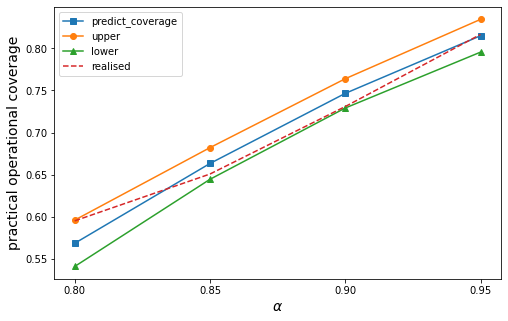

In [45]:
result=np.zeros((4,5))
result[:,0]=nominalo
result[:,1]=proba
result[:,2]=upper
result[:,3]=lower
result[:,4]=exact_ratio

import pandas as pd

df_yo = pd.DataFrame(result, columns = ['nominal','predict_coverage','upper','lower','realised'])

plt.rcParams["figure.figsize"] = (8,5)
df_yo.plot(x="nominal",style=['s-','o-','^-',"--"])
plt.ylabel('practical operational coverage',fontsize=14)
plt.xlabel(r"$\alpha$",fontsize=14)
plt.xticks([0.80,0.85,0.90,0.95])

## build the calibration curve
It is easy to obtain an inverse function of the logistic regression, using `logit` function

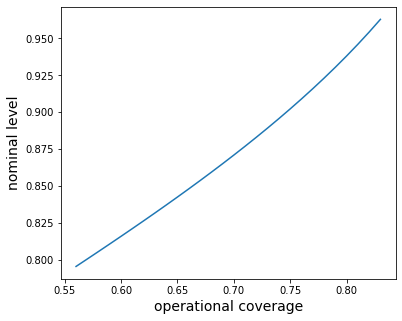

In [28]:
# inverse map ,take yo for example
def logit(p):
    return np.log(p / (1 - p))

def inverse_map(target):
    f=(logit(target)-np.dot(clf.coef_[:,1:],yo_encoder_s[1,1:])-clf.intercept_)/clf.coef_[:,0]
    x_vec=np.zeros(yo_encoder_s.shape[1])
    x_vec[0]=f
    X_vec=scaler.inverse_transform(x_vec)
    nominal=X_vec[0]
    return nominal

# the desired nominal level
ix=np.arange(0.56,0.84,0.01)
# the correct nominal level
iy=[inverse_map(ix[i]) for i in range(len(ix))]

plt.rcParams["figure.figsize"] = (6,5)
plt.plot(ix,iy)
# plt.title('nominal levels estimation',fontsize=20)
plt.xlabel("operational coverage",fontsize=14)
plt.ylabel("nominal level",fontsize=14)

plt.show()

### display the calibrated region

take desired nominal level at 0.8

In [29]:
alpha_new=inverse_map(0.8)


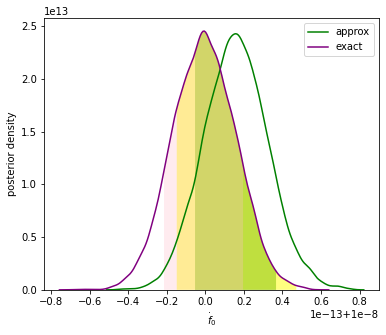

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

samples_est = fdot_chain_est[burnin::]
samples = fdot_chain[burnin::]

lower_bound_est_new, upper_bound_est_new = np.percentile(samples_est, [(1-alpha_new)*50, (1-(1-alpha_new)/2)*100])
lower_bound_est, upper_bound_est = np.percentile(samples_est, [10, 90])
lower_bound, upper_bound = np.percentile(samples, [10, 90])

x1 =  np.arange(lower_bound, upper_bound, 1e-15)
kde1 = gaussian_kde(samples)
y1 = kde1.evaluate(x1)

x2 =  np.arange(lower_bound_est, upper_bound_est, 1e-15)
kde2 = gaussian_kde(samples_est)
y2 = kde1.evaluate(x2)

x3 =  np.arange(lower_bound_est_new, upper_bound_est_new, 1e-15)
y3 = kde1.evaluate(x3)


# Create a kernel density estimate plot of the data
# hard code to display the calibrated region, the yellow one is the calibrated region.
sns.kdeplot(samples_est,c='green',label="approx")
sns.kdeplot(samples,c='purple',label="exact")
plt.fill_between(x2, y2, alpha=0.5,facecolor="green")
plt.fill_between(x3, y3, alpha=0.5,facecolor="yellow")
plt.fill_between(x1, y1, alpha=0.3,facecolor="pink")



plt.legend(loc='upper right')
plt.xlabel(r'$\dot{f}_{0}$')
plt.ylabel("posterior density")
plt.show()